## Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats.


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_excel("../content/результаты А_B.xlsx")

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Основные показатели:

In [3]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


Проверка наличия повторяющихся пользователей:

In [4]:
df["userid"].count() == df["userid"].nunique()

True

Все уникальные

Проверим распределние пользователей между версиями:

In [5]:
df["userid"].nunique()

90189

In [6]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


Примерно одинаковы

Подсчет количества игроков для каждого количества игровых раундов:

In [7]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Построение графика распределения игроков, сыгравших от 0 до 100 игровых раундов:

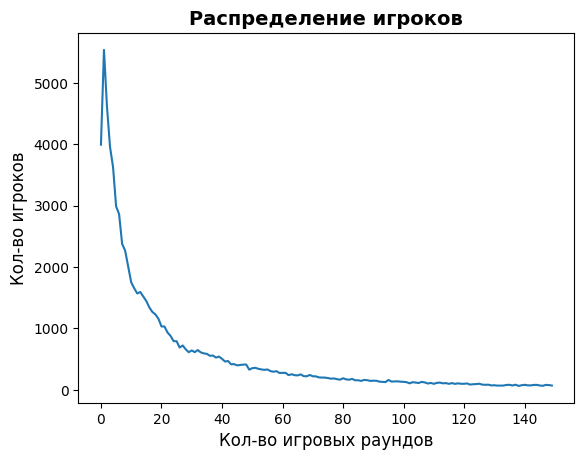

In [8]:
ax = plot_df.head(150).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("Кол-во игровых раундов", size=12)
plt.ylabel("Кол-во игроков", size=12)
plt.show()

In [9]:
df.query("sum_gamerounds == 0").userid.count()

3994

In [10]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"коэффициент удержания за 1 день: {round(df_retention[0],2)} %")
print(f"коэффициент удержания за неделю: {round(df_retention[1],2)} %")

коэффициент удержания за 1 день: 44.52 %
коэффициент удержания за неделю: 18.61 %


Это кол-во игроков которые установили но не запустили игру, что видно по графику выше.
чуть меньше половины игроков возвращаются через день после установки игры. 18.61% игроков возвращаются через 7 дней после установки игры.

### Проверка на распределение

In [11]:
df.query('version == "gate_30" and retention_1 == False').sum_gamerounds
display(stats.kstest(df.sum_gamerounds, 'norm'))
display(stats.kstest(df.sum_gamerounds, 'expon'))
display(stats.kstest(df.sum_gamerounds, 'binom', args=(1500, 0.16)))

KstestResult(statistic=0.8715607041848303, pvalue=0.0, statistic_location=2, statistic_sign=-1)

KstestResult(statistic=0.7934532380996653, pvalue=0.0, statistic_location=3, statistic_sign=-1)

KstestResult(statistic=0.9398360749415627, pvalue=0.0, statistic_location=200, statistic_sign=1)

In [12]:
df.query('version == "gate_30" and retention_1 == True and retention_7 == True').userid.count()

6676

In [13]:
df.query('version == "gate_40" and retention_1 == True and retention_7 == True').userid.count()

6506

### Bootstrapping

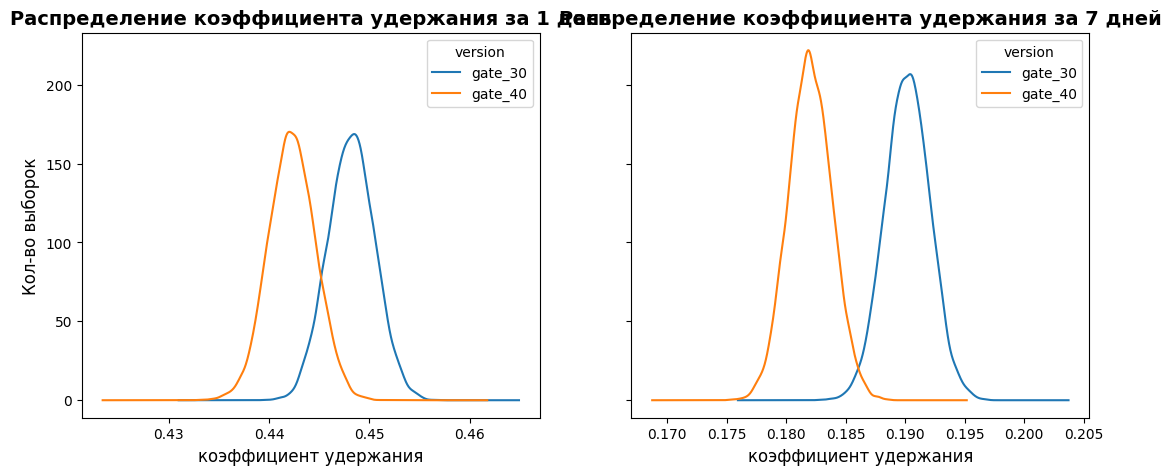

In [14]:
boot_1d = pd.DataFrame([df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean() for _ in range(10000)])
boot_7d = pd.DataFrame([df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean() for _ in range(10000)])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания", size=12)
ax1.set_ylabel("Кол-во выборок", size=12)
ax1.set_title("Распределение коэффициента удержания за 1 день", fontweight="bold", size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания", size=12)
ax2.set_title("Распределение коэффициента удержания за 7 дней", fontweight="bold", size=14)
plt.show()

Эти распределения представляют собой неопределенность Bootstrapping относительно того, каким может быть удержание за 1 и 7 дней
по графикам видно что есть некоторая разница, но не достаточно.

Необходимо увеличить различия

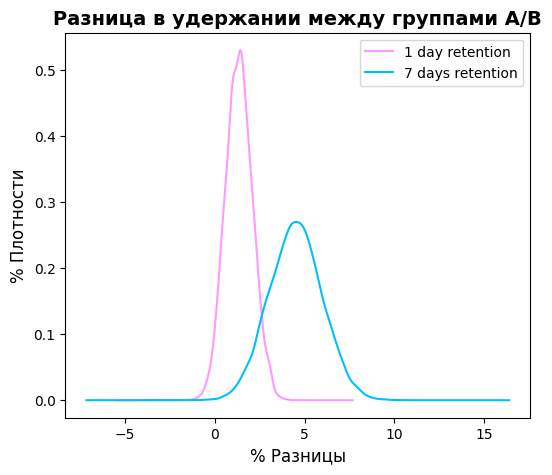

In [16]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% Разницы",size=12)
ax1.set_ylabel("% Плотности",size=12)
ax1.set_title("Разница в удержании между группами A/B", fontweight="bold", size=14)
plt.legend()
plt.show()

Из этой диаграммы мы видно, что наиболее вероятная разница в процентах составляет около 1-2% при удержании в течение 1 дня. При 7-дневном хранении наиболее вероятная разница в процентах составляет около 2-5%. Более того, большая часть распределения выше 0% в пользу gate_30. 

Какова вероятность того, что разница превысит 0%:

In [19]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f"Вероятность того, что 1-дневное удержание выше, в пользу gate_30: {round(prob_1,2)*100} %")
print(f"Вероятность 7-дневного удержания выше, в пользу gate_30: {(prob_7)*100} %")

Вероятность того, что 1-дневное удержание выше, в пользу gate_30: 97.0 %
Вероятность 7-дневного удержания выше, в пользу gate_30: 99.89 %


### Вывод

Результат начальной загрузки говорит, что вероятность 99,89 % того, что 7-дневное удержание выше, в пользу gate_30.

Следует оставить gate_30.